In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import collections

### Data loading

In [56]:
def readpath(path):
    f = open(path,'r')
    caption = f.read()
    f.close()
    return caption

In [57]:
caption = readpath('captions.txt/captions.txt')

In [58]:
caption = caption.split('\n')

In [59]:
caption = caption[1:-1]

In [62]:
description = {}

for text in caption:
    
    first,second = text.split('.jpg,')
    
    if description.get(first) is None:
        description[first] = []
        
    description[first].append(second)
    

### Data Cleaning

In [68]:
def clean_text(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    
    sentence = ' '.join(sentence)
    return sentence 

In [72]:
for img,captions in description.items():
    
    for i in range(len(captions)):
        captions[i] = clean_text(captions[i])
    

In [75]:
with open('descriptions.txt','w') as f:
     f.write(str(description))

### Vocab Building

In [6]:
description = None
with open('descriptions.txt','r') as f:
     description = f.read()
        
accept = description.replace("'","\"")
description = json.loads(accept)

In [7]:
description['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [8]:
total_words = []

for key in description.keys():
    [total_words.append(i) for ds in description[key] for i in ds.split()]


In [11]:
import collections
counter = collections.Counter(total_words)
freq_cnt  = dict(counter)


In [12]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [13]:
len(total_words)

1845

### Train and Test Data

In [8]:

train = list(description.keys())[:6001]
test = list(description.keys())[6001:]

In [9]:
print(len(train),len(test))

6001 2090


In [46]:
train_description = {}

for img_id in train:
    train_description[img_id] = []
    for cap in description[img_id]:
        cap_to_append = 'startseq '+cap+' endseq'
        train_description[img_id].append(cap_to_append)


### Image Featurisation using Resnet 50

In [18]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model_new = Model(model.input,model.layers[-2].output)

In [46]:
def preprocess_image(img):
    
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    
    return img

In [47]:
img = preprocess_image('./Images/997722733_0cb5439472.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


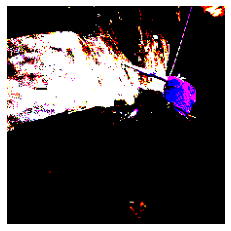

In [48]:
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [49]:
IMG_PATH = './Images/'

In [50]:
def encode_img(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [52]:
feat_vec = encode_img('./Images/997722733_0cb5439472.jpg')

In [59]:
encoding_train = {}
for img_id in tqdm(train):
    
    img_path = IMG_PATH + img_id+ '.jpg'
    encoding_train[img_id] = encode_img(img_path)
    
    
    


100%|██████████| 6001/6001 [38:20<00:00,  2.61it/s]  


In [60]:
with open('encoded_train.pkl','wb') as f:
     pickle.dump(encoding_train,f)

In [61]:
encoding_test = {}
for img_id in tqdm(test):
    
    img_path = IMG_PATH + img_id+ '.jpg'
    encoding_test[img_id] = encode_img(img_path)
    
with open('encoded_test.pkl','wb') as f:
     pickle.dump(encoding_test,f)

100%|██████████| 2090/2090 [11:43<00:00,  2.97it/s]


In [56]:
with open('encoded_train.pkl', 'rb') as pickle_file:
    encoding_train= pickle.load(pickle_file)

In [65]:
with open('encoded_train.pkl', 'rb') as pickle_file:
    encoding_test= pickle.load(pickle_file)

### Data Preprocessing for captions

In [14]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    
    word_to_idx[word]=i+1
    idx_to_word[i+1] = word
    
    


In [15]:
word_to_idx['dog']
idx_to_word[6]

'dog'

In [16]:
print(len(idx_to_word))

1845


In [17]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847



In [18]:
vocab_size = len(word_to_idx)+1
print(f"vocab size:{vocab_size}")

vocab size:1848


## Custom Data Generator

In [63]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y = [],[],[]
    n=0
    
    while True:
        for key,desc_list in train_description.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq =[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
                    
                    
                if n==batch_size:
                    
                    yield ([np.array(x1),np.array(x2)],np.array(y))
                    x1,x2,y = [],[],[]
                    n=0 
                         
                
    

### Word Embeddings

In [26]:
f = open('./glove.6B/glove.6B.50d.txt',encoding='utf8')

In [27]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    
    
 

In [28]:
f.close()

In [30]:
def get_embedding_matrix():
    
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
     
    

In [31]:
embedding_matrix = get_embedding_matrix()

In [32]:
print(embedding_matrix.shape)

(1848, 50)


### Model Architecture

In [34]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [36]:
max_len = 35

In [37]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [38]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Train the model

In [49]:
epochs = 20
batch_size = 3
steps = len(train_description)//3

In [50]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [64]:
train()

2000/2000 [==============================] - 422s 211ms/step - loss: 2.5650


In [66]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() 
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

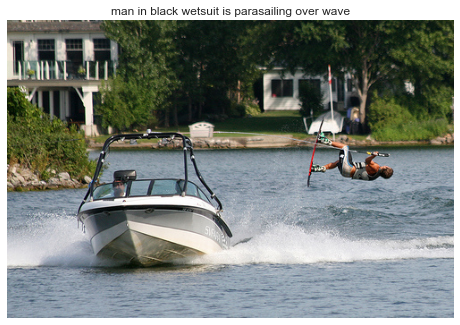

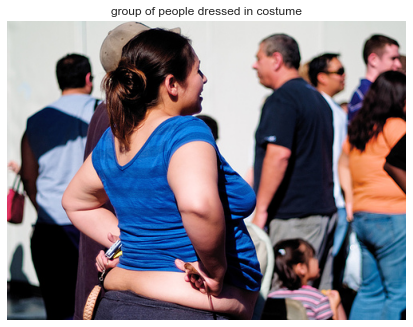

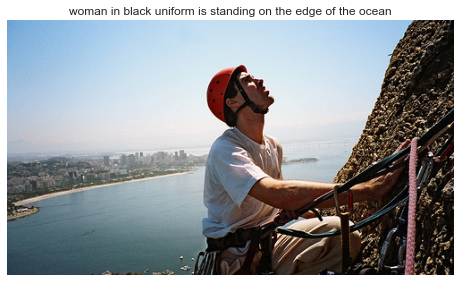

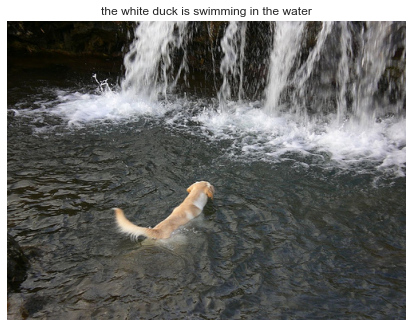

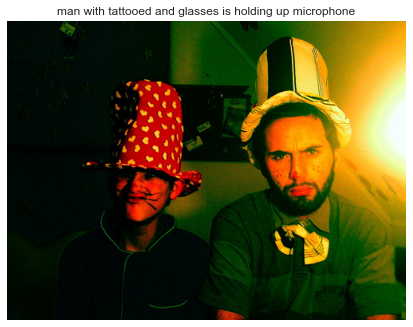

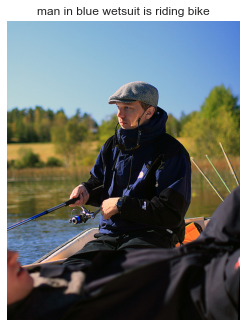

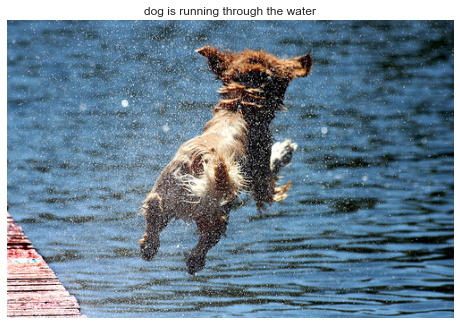

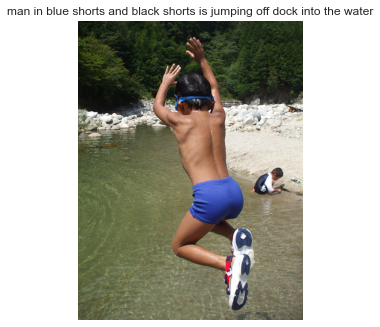

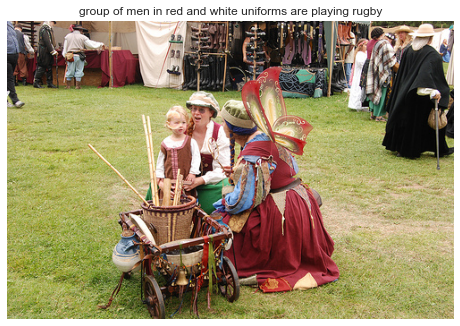

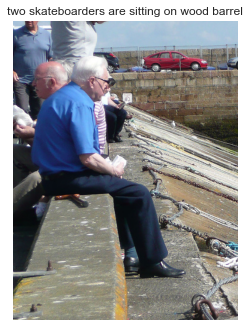

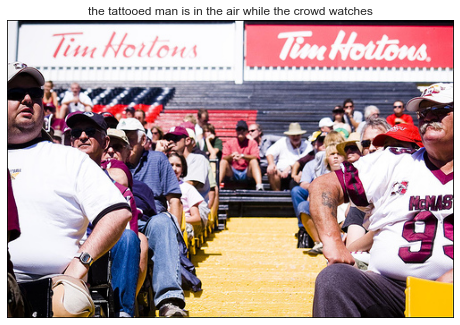

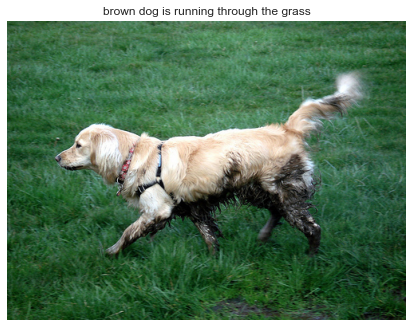

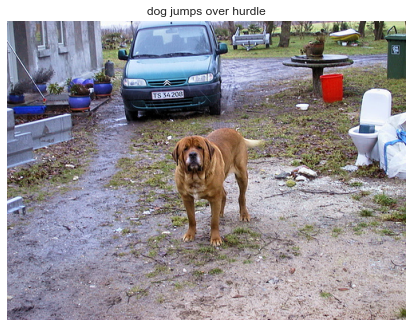

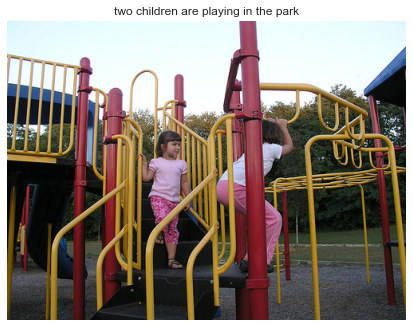

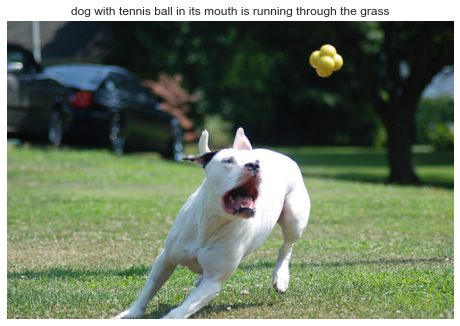

In [67]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [19]:
with open('w2i.pkl','wb') as f:
    pickle.dump(word_to_idx,f)

In [20]:
with open('i2w.pkl','wb') as f:
    pickle.dump(idx_to_word,f)

In [ ]:
http://localhost:8888/view/Image%20Caption/Images/1002674143_1b742ab4b8.jpg